In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import qiskit

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
test_image = Image.open('test_4x4_image.tif')
np_test_image = np.array(test_image)

test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append(pixel[0] / 256)

np_test_image_final = np.array(test_image_final)

np_test_image = np_test_image_final.reshape((4,4))
print(np_test_image)

[[0.8125     0.84765625 0.86328125 0.8515625 ]
 [0.88671875 0.89453125 0.22265625 0.8984375 ]
 [0.2890625  0.890625   0.49609375 0.8984375 ]
 [0.43359375 0.89453125 0.38671875 0.4375    ]]


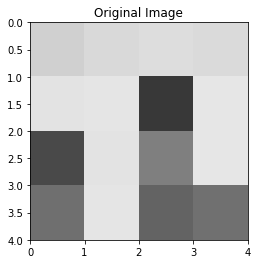

In [3]:
def plot_image4x4(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image4x4(np_test_image, "Original Image")   

[[0.2778443  0.2898664  0.29520956 0.29120219]
 [0.3032243  0.30589588 0.07614002 0.30723167]
 [0.09884845 0.30456009 0.16964532 0.30723167]
 [0.14827268 0.30589588 0.1322432  0.14960847]]


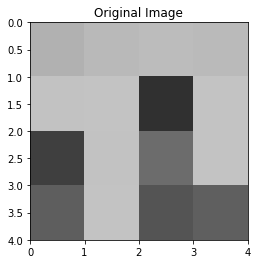

In [4]:
# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array

def plot_image4x4_bright(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 4, 4, 0], vmin=0, vmax=0.4, cmap='gray')
    plt.show()
    
np_test_image_normalized = normalize(np_test_image.reshape((1,16)))
np_test_image_normalized = np_test_image_normalized.reshape((4,4))

print(np_test_image_normalized)

plot_image4x4_bright(np_test_image_normalized, "Original Image")   

In [5]:
def ansatz(param, ansatz_num_layers):    
    num_q = 4
    qc = QuantumCircuit(num_q, num_q)    
    for ansatz_j in range(ansatz_num_layers):        
        for ansatz_i in range(num_q):
            qc.ry(param[ansatz_i + ansatz_j*num_q], ansatz_i)        
        if ansatz_j < ansatz_num_layers-1:            
            qc.cx(0,1)
            qc.cx(1,2)
            qc.cx(2,3)
            qc.cx(3,0)
    qc.barrier()
    qc.measure(range(num_q), range(num_q))      
    return qc

In [6]:
def loss_function(params, loss_num_layers, loss_num_shots):
    
    # We will optimize this quantity as well
    num_shots = loss_num_shots
    circ = ansatz(param=params, ansatz_num_layers=loss_num_layers)
    counts = execute(circ, backend=simulator, shots=num_shots).result().get_counts(circ)
    
    strings = []
    for loss_i in range(16):
        strings.append(get_bin(loss_i,4))
    
    for loss_i in strings:
        if loss_i not in counts:
            counts[loss_i] = 0
    
    p = [counts[string]/num_shots for string in strings]
    
    return sum([(p[loss_i] - np_test_image_normalized[loss_i])**2 for loss_i in range(len(np_test_image_normalized))])
    # Other Loss Functions:
    #return sum([abs(p[i] - prob_distr[i]) for i in range(len(prob_distr))])
    #return sum([ prob_distr[i]*math.log2(p[i]) for i in range(len(prob_distr))])

In [7]:
# Training the Quantum Circuit
import scipy.optimize as spo

In [13]:
np_test_image_normalized = np_test_image_normalized.reshape(16)

# Setting up the simulator:
simulator = Aer.get_backend('aer_simulator')
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)


# res = spo.minimize(loss_function, np.ones(4 * 5), args=(5,4000), method="COBYLA")
minim_kwargs = {"method":"COBYLA", "args":(10, 16000)}
res = spo.basinhopping(loss_function, np.ones(4 * 10), minimizer_kwargs=minim_kwargs, niter=100)

print(res.x)

[20.3894816  18.02273499 24.77451361 19.41226744 15.45411217 12.62740883
  6.89755627  7.60452333 12.69604778 11.32128826 11.15443358  7.60654981
  6.86593435  4.37483347  0.38375222  3.69661565  8.35885874 10.09129986
  6.13470835  6.59110081 -4.31010815  3.82455583  0.21096317  6.19635895
  4.81032818  1.41227066  7.36358347  2.3083785  -2.56166876  5.57765718
  1.1011375  -3.74781906  3.07562406  1.64802533  2.23487996  3.89649405
  2.73539976  2.30508499  1.40872258  3.53107343]


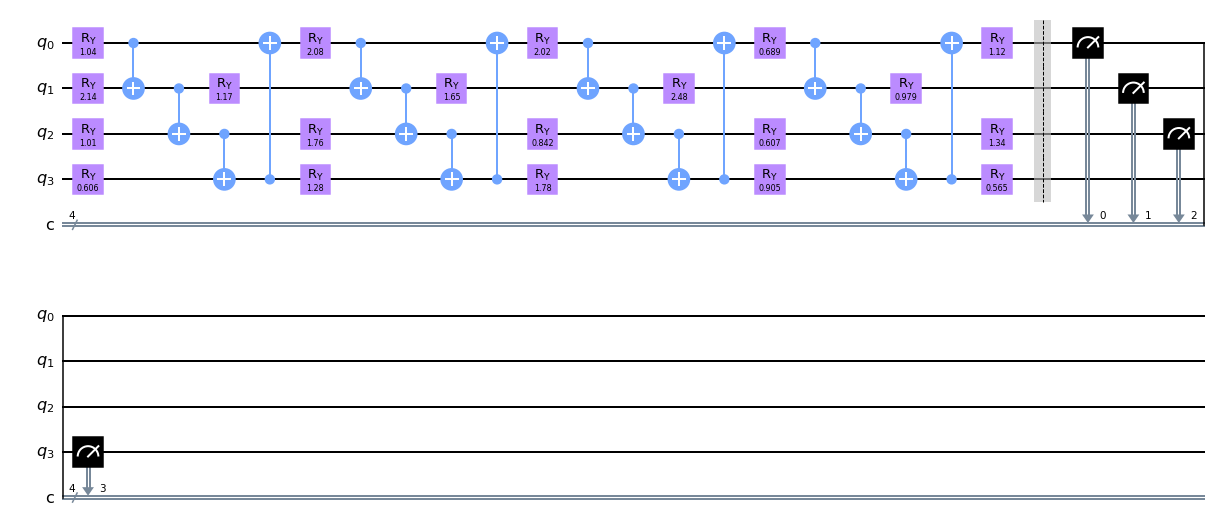

In [9]:
optimized_params = res.x

trained_ansatz = ansatz(optimized_params, 5)

trained_ansatz.draw()

In [10]:
simulator = Aer.get_backend('aer_simulator')
trained_ansatz_transpiled = transpile(trained_ansatz, simulator)

# Run and get statevector
result = simulator.run(trained_ansatz_transpiled).result()
counts = result.get_counts()

print(counts)

{'1110': 1, '0100': 235, '1111': 58, '0001': 141, '0000': 259, '0010': 19, '1101': 9, '1100': 47, '0110': 96, '1000': 6, '1010': 68, '1001': 4, '0101': 62, '1011': 19}


[[0.50292115 0.37107319 0.13621559 0.        ]
 [0.47905343 0.24606275 0.30618622 0.        ]
 [0.07654655 0.0625     0.2576941  0.13621559]
 [0.21423921 0.09375    0.03125    0.23799291]]


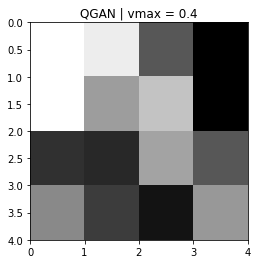

In [12]:
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)

qGAN_output = []
for i in range(16):
    if get_bin(i, 4) in counts:
        qGAN_output.append(np.sqrt( ( counts.get(get_bin(i, 4)) / 16000 ) ) )
    else:
        qGAN_output.append(0)
        
np_qGAN_output = np.array(qGAN_output).reshape((4,4))
np_qGAN_output = normalize(np_qGAN_output)

print(np_qGAN_output)

plot_image4x4_bright(np_qGAN_output, "QGAN | vmax = 0.4")   

In [21]:
# We want to quantify error
# Let's calculate the RMSE for our simulator output:
def un_normalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

def rmse_image_error(true_image, error_image, n):
    rms_error = 0.0
    for y in range(n):
        for x in range(n):
            rms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    rms_error = np.sqrt(rms_error)
    return (rms_error / (n**2))

In [23]:
print(np_test_image[1][1])
print(np_test_image_normalized)
test = un_normalize(np_test_image, np_test_image_normalized, np_test_image_normalized, 4)

0.89453125
[0.2778443  0.2898664  0.29520956 0.29120219 0.3032243  0.30589588
 0.07614002 0.30723167 0.09884845 0.30456009 0.16964532 0.30723167
 0.14827268 0.30589588 0.1322432  0.14960847]
Traceback (most recent call last):
  Input In [23] in <cell line: 3>
    test = un_normalize(np_test_image, np_test_image_normalized, np_test_image_normalized, 4)
  Input In [21] in un_normalize
    normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
IndexError: invalid index to scalar variable.

Use %tb to get the full traceback.


In [24]:
rmse_error = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized.reshape((4,4)), np_qGAN_output, 4), 4)
print(rmse_error)

0.04503581547783959


In [32]:
import time
import datetime

print(time.time())
print(datetime.datetime.now() + datetime.timedelta(hours=5.5))

1670402051.8471885
2022-12-07 14:04:11.847379


num_layers =  1
Beginning Training @  2022-12-07 14:07:31.507067
Finished Training @  2022-12-07 14:10:50.657413
Time Elapsed:  199.1503472328186 s.


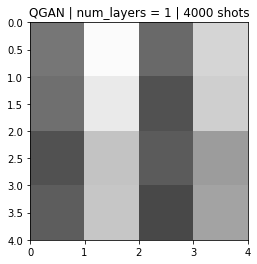

-X-X-X-X-X-X-X-
num_layers =  2
Beginning Training @  2022-12-07 14:10:51.039180
Finished Training @  2022-12-07 14:18:51.286365
Time Elapsed:  480.24718499183655 s.


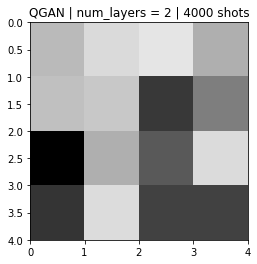

-X-X-X-X-X-X-X-
num_layers =  3
Beginning Training @  2022-12-07 14:18:51.500366
Finished Training @  2022-12-07 14:30:03.234070
Time Elapsed:  671.7337040901184 s.


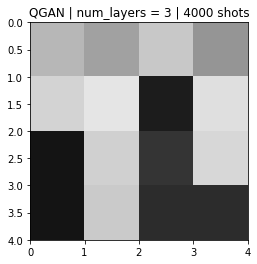

-X-X-X-X-X-X-X-
num_layers =  4
Beginning Training @  2022-12-07 14:30:03.437048
Finished Training @  2022-12-07 14:45:42.919042
Time Elapsed:  939.4819917678833 s.


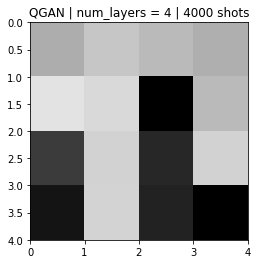

-X-X-X-X-X-X-X-
num_layers =  5
Beginning Training @  2022-12-07 14:45:43.305337
Finished Training @  2022-12-07 15:09:43.634722
Time Elapsed:  1440.3293855190277 s.


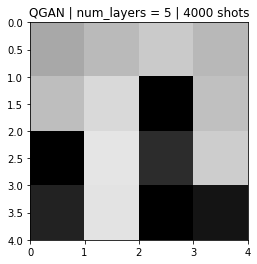

-X-X-X-X-X-X-X-
num_layers =  6
Beginning Training @  2022-12-07 15:09:43.917110
Finished Training @  2022-12-07 15:34:41.377285
Time Elapsed:  1497.460171699524 s.


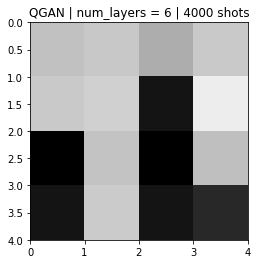

-X-X-X-X-X-X-X-
num_layers =  7
Beginning Training @  2022-12-07 15:34:41.590688
Finished Training @  2022-12-07 17:34:50.836233
Time Elapsed:  2714.171865940094 s.


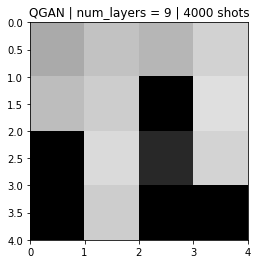

-X-X-X-X-X-X-X-
num_layers =  10
Beginning Training @  2022-12-07 17:34:51.090679


In [ ]:
num_layers_array = [1,2,3,4,5,6,7,8,9,10]
num_shots_array = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

# Setting up the simulator:
simulator = Aer.get_backend('aer_simulator')
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)

#Let's see how number of layers affects the image output
num_layers_array_rmse_error = []
for num_layers_value in num_layers_array:
    print("num_layers = ", num_layers_value)
    # Define and Train the QGAN
    start_time = time.time()
    print("Beginning Training @ ", (datetime.datetime.now() + datetime.timedelta(hours=5.5)))
    # res = spo.minimize(loss_function, np.ones(4 * num_layers_value), args=(num_layers_value, 4000), method="COBYLA")
    minim_kwargs = {"method":"COBYLA", "args":(num_layers_value, 4000)}
    res = spo.basinhopping(loss_function, np.ones(4 * num_layers_value), minimizer_kwargs=minim_kwargs, niter=100)
    end_time = time.time()
    print("Finished Training @ ", (datetime.datetime.now() + datetime.timedelta(hours=5.5)))
    print("Time Elapsed: ", (end_time - start_time), "s.")
    optimized_params = res.x
    trained_ansatz = ansatz(optimized_params, num_layers_value)
    
    # Run the QGAN
    trained_ansatz_transpiled = transpile(trained_ansatz, simulator)
    result = simulator.run(trained_ansatz_transpiled).result()
    counts = result.get_counts()
    
    # Construct the image from QGAN circuit output
    qGAN_output = []
    for i in range(16):
        if get_bin(i, 4) in counts:
            qGAN_output.append(np.sqrt( ( counts.get(get_bin(i, 4)) / 4000 ) ) )
        else:
            qGAN_output.append(0)
        
    np_qGAN_output = np.array(qGAN_output).reshape((4,4))
    np_qGAN_output = normalize(np_qGAN_output)
    
    # Print image output
    title_string = "QGAN | num_layers = {} | 4000 shots".format(num_layers_value)
    plot_image4x4_bright(np_qGAN_output, title_string)

    # Calculate error
    rmse_error = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized.reshape((4,4)), np_qGAN_output, 4), 4)
    num_layers_array_rmse_error.append(rmse_error)
    
    print("-X-X-X-X-X-X-X-")
    
print(num_layers_array_rmse_error)

In [ ]:
# RMSE Error isn't really effective in determining how well increasing the number of layers leads to a better iamge
# We'll do this for a 8x8 image and use SSIM to get a better idea of how similar the images are

In [2]:
test_image_8x8 = Image.open('clock_test_image_8x8.tif')
np_test_image_8x8 = np.array(test_image_8x8)

test_image_8x8_final = []
for row in np_test_image_8x8:
    for pixel in row:
        test_image_8x8_final.append(pixel[0] / 256)

np_test_image_8x8_final = np.array(test_image_8x8_final)

np_test_image_8x8 = np_test_image_8x8_final.reshape((8,8))
print(np_test_image_8x8)

[[0.734375   0.7890625  0.80859375 0.8203125  0.828125   0.81640625
  0.80859375 0.77734375]
 [0.79296875 0.859375   0.87109375 0.87890625 0.890625   0.90234375
  0.890625   0.859375  ]
 [0.84375    0.890625   0.89453125 0.90625    0.859375   0.6328125
  0.77734375 0.90234375]
 [0.86328125 0.8984375  0.8984375  0.91796875 0.7734375  0.31640625
  0.453125   0.94140625]
 [0.89453125 0.9375     0.91796875 0.91796875 0.8203125  0.26171875
  0.4375     0.96875   ]
 [0.68359375 0.51953125 0.6953125  0.953125   0.734375   0.3359375
  0.49609375 0.65625   ]
 [0.5625     0.5390625  0.52734375 0.99609375 0.4140625  0.16796875
  0.22265625 0.33203125]
 [0.61328125 0.6171875  0.71484375 0.90625    0.73046875 0.55859375
  0.5625     0.578125  ]]


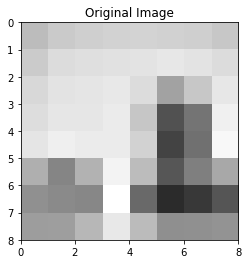

In [3]:
def plot_image_8x8(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 8, 8, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image_8x8(np_test_image_8x8, "Original Image")   

[[0.12184001 0.1309132  0.13415363 0.13609788 0.13739405 0.1354498
  0.13415363 0.12896894]
 [0.13156128 0.14257873 0.14452299 0.14581916 0.14776341 0.14970767
  0.14776341 0.14257873]
 [0.13998639 0.14776341 0.1484115  0.15035575 0.14257873 0.10498979
  0.12896894 0.14970767]
 [0.14322682 0.14905958 0.14905958 0.15230001 0.12832086 0.0524949
  0.07517788 0.15618852]
 [0.1484115  0.15554043 0.15230001 0.15230001 0.13609788 0.0434217
  0.07258554 0.16072512]
 [0.1134149  0.08619532 0.11535916 0.15813278 0.12184001 0.05573532
  0.08230681 0.1088783 ]
 [0.09332426 0.08943575 0.08749149 0.16526171 0.06869703 0.02786766
  0.03694085 0.05508724]
 [0.10174937 0.10239745 0.11859958 0.15035575 0.12119192 0.09267618
  0.09332426 0.0959166 ]]


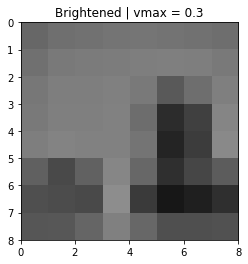

In [5]:
# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array

def plot_image_8x8_bright(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 8, 8, 0], vmin=0, vmax=0.3, cmap='gray')
    plt.show()
    
np_test_image_8x8_normalized = normalize(np_test_image_8x8.reshape((1,64)))
np_test_image_8x8_normalized = np_test_image_8x8_normalized.reshape((8,8))

print(np_test_image_8x8_normalized)

plot_image_8x8_bright(np_test_image_8x8_normalized, "Brightened | vmax = 0.3")   

In [12]:
def ansatz_8x8(param, ansatz_num_layers):    
    num_q = 6
    qc = QuantumCircuit(num_q, num_q)    
    for ansatz_j in range(ansatz_num_layers):        
        for ansatz_i in range(num_q):
            qc.ry(param[ansatz_i + ansatz_j*num_q], ansatz_i)        
        if ansatz_j < ansatz_num_layers-1:            
            qc.cx(0,1)
            qc.cx(1,2)
            qc.cx(2,3)
            qc.cx(3,4)
            qc.cx(4,5)
            qc.cx(5,0)
            qc.barrier()
    qc.measure(range(num_q), range(num_q))      
    return qc

In [18]:
import math

def loss_function_8x8(params, loss_num_layers, loss_num_shots):
    # We will optimize this quantity as well
    num_shots = loss_num_shots
    circ = ansatz_8x8(param=params, ansatz_num_layers=loss_num_layers)
    counts = execute(circ, backend=simulator, shots=num_shots).result().get_counts(circ)
    
    strings = []
    for loss_i in range(2**6):
        strings.append(get_bin(loss_i,6))
    
    for loss_i in strings:
        if loss_i not in counts:
            counts[loss_i] = 0
    
    p = [counts[string]/num_shots for string in strings]
    for i_test in range(len(np_test_image_8x8_normalized)):
        if p[i_test] == 0:
            p[i_test] = 0.000001
    
    #return sum([(p[loss_i] - np_test_image_8x8_normalized[loss_i])**2 for loss_i in range(len(np_test_image_8x8_normalized))])
    #return sum([abs(p[loss_i] - np_test_image_8x8_normalized[loss_i]) for loss_i in range(len(np_test_image_8x8_normalized))])
    return sum([ np_test_image_8x8_normalized[loss_i]*math.log2(p[loss_i]) for loss_i in range(len(np_test_image_8x8_normalized))])

In [14]:
# Training the Quantum Circuit
import scipy.optimize as spo
np_test_image_8x8_normalized = np_test_image_8x8_normalized.reshape(64)

# Using SSIM
from skimage.metrics import structural_similarity as ssim

def un_normalize(true_image, true_image_normalized, image, n):
    perfect_image = true_image.reshape((n,n))
    normal_image = true_image_normalized.reshape((n,n))
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (normal_image[y][x] / perfect_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

# For Timing the learning 
import time

num_layers =  1
Beginning Training @  2022-12-04 13:57:38.622868
Training Completed @  2022-12-04 13:57:54.183845  | Time Elasped:  15.560975551605225 s.


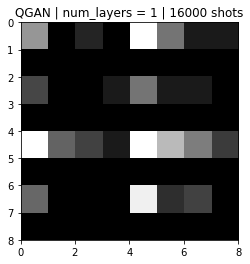

SSIM Error:  -0.009821031377792565
-X-X-X-X-X-X-X-
num_layers =  2
Beginning Training @  2022-12-04 13:57:54.311207
Training Completed @  2022-12-04 13:58:29.688884  | Time Elasped:  35.37767577171326 s.


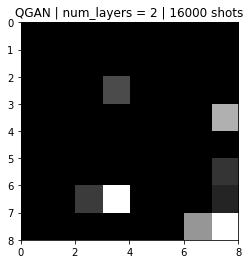

SSIM Error:  0.049642701681232936
-X-X-X-X-X-X-X-
num_layers =  3
Beginning Training @  2022-12-04 13:58:29.929078
Training Completed @  2022-12-04 13:59:17.831216  | Time Elasped:  47.902138233184814 s.


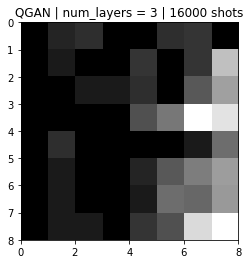

SSIM Error:  -0.16215146381790438
-X-X-X-X-X-X-X-
num_layers =  4
Beginning Training @  2022-12-04 13:59:18.102284
Training Completed @  2022-12-04 14:00:26.699683  | Time Elasped:  68.59739899635315 s.


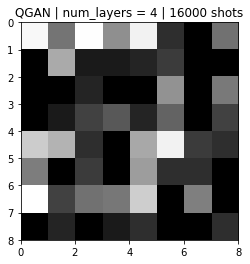

SSIM Error:  -0.0904343440915627
-X-X-X-X-X-X-X-
num_layers =  5
Beginning Training @  2022-12-04 14:00:26.878096
Training Completed @  2022-12-04 14:01:52.654750  | Time Elasped:  85.77665305137634 s.


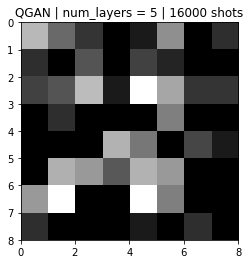

SSIM Error:  -0.06919704592845835
-X-X-X-X-X-X-X-
num_layers =  6
Beginning Training @  2022-12-04 14:01:53.024185
Training Completed @  2022-12-04 14:03:28.308472  | Time Elasped:  95.28428626060486 s.


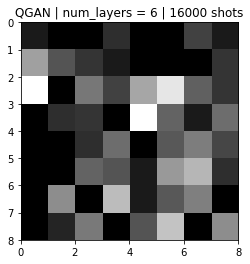

SSIM Error:  -0.07522998724322971
-X-X-X-X-X-X-X-
num_layers =  7
Beginning Training @  2022-12-04 14:03:28.544408
Training Completed @  2022-12-04 14:05:58.830788  | Time Elasped:  150.28638005256653 s.


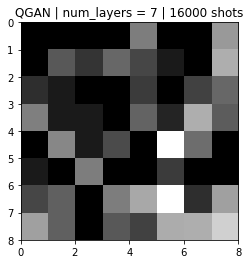

SSIM Error:  -0.26672779196978524
-X-X-X-X-X-X-X-
num_layers =  8
Beginning Training @  2022-12-04 14:05:59.001438
Training Completed @  2022-12-04 14:08:20.173957  | Time Elasped:  141.17251825332642 s.


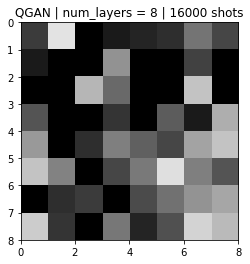

SSIM Error:  -0.22496927256857022
-X-X-X-X-X-X-X-
num_layers =  9
Beginning Training @  2022-12-04 14:08:20.510535
Training Completed @  2022-12-04 14:10:43.522690  | Time Elasped:  143.01215410232544 s.


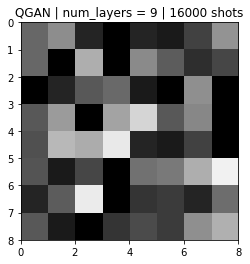

SSIM Error:  0.0015622049257141783
-X-X-X-X-X-X-X-
num_layers =  10
Beginning Training @  2022-12-04 14:10:43.889227
Training Completed @  2022-12-04 14:13:45.064152  | Time Elasped:  181.1749231815338 s.


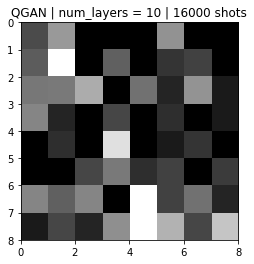

SSIM Error:  -0.019908788698616158
-X-X-X-X-X-X-X-


In [19]:
from datetime import datetime

# Here goes!
num_layers_array = [1,2,3,4,5,6,7,8,9,10]
num_shots_array = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

# Setting up the simulator:
simulator = Aer.get_backend('aer_simulator')
# Lambda to convert between integer and it's binary string representation
get_bin = lambda x, n: format(x, 'b').zfill(n)

#Let's see how number of layers affects the image output
num_layers_qGAN_output = []
num_layers_SSIM_error = []
for num_layers_value in num_layers_array:
    print("num_layers = ", num_layers_value)
    # Define and Train the QGAN
    start_training = time.time()
    print("Beginning Training @ ", datetime.now())
    res = spo.minimize(loss_function_8x8, np.ones(6 * num_layers_value), args=(num_layers_value, 64000), method="COBYLA")
    end_training = time.time()
    print("Training Completed @ ", datetime.now(), " | Time Elasped: ", (end_training - start_training), "s.")
    optimized_params = res.x
    trained_ansatz = ansatz_8x8(optimized_params, num_layers_value)
    
    # Run the QGAN
    trained_ansatz_transpiled = transpile(trained_ansatz, simulator)
    result = simulator.run(trained_ansatz_transpiled).result()
    counts = result.get_counts()
    
    # Construct the image from QGAN circuit output
    qGAN_output = []
    for i in range(64):
        if get_bin(i, 6) in counts:
            qGAN_output.append(np.sqrt( ( counts.get(get_bin(i, 6)) / 64000 ) ) )
        else:
            qGAN_output.append(0)
        
    np_qGAN_output = np.array(qGAN_output).reshape((8,8))
    np_qGAN_output = normalize(np_qGAN_output)
    
    num_layers_qGAN_output.append(np_qGAN_output)
    
    # Print image output
    title_string = "QGAN | num_layers = {} | 16000 shots".format(num_layers_value)
    plot_image_8x8_bright(np_qGAN_output, title_string)
    
    np_qGAN_output_unnormalized = un_normalize(np_test_image_8x8, np_test_image_8x8_normalized, np_qGAN_output, 8)
    ssim_error = ssim(np_test_image_8x8, np_qGAN_output_unnormalized, data_range=np_qGAN_output_unnormalized.max() - np_qGAN_output_unnormalized.min() )
    print("SSIM Error: ", ssim_error)
    num_layers_SSIM_error.append(ssim_error)
    
    print("-X-X-X-X-X-X-X-")
    